In [1]:
''' use base anaconda kernel '''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image

import time

from pathlib import Path

import cv2 as cv

import torch
import torchvision 

In [2]:
# loading in the data

# load in the dataframe:

df_cleaned = pd.read_csv('df_cleaned.csv')

df_cleaned.head()

/tmp/ipykernel_2018/2402431355.py:5: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('df_cleaned.csv')


,name,videoName,frameIndex,id,category,attributes.crowd,attributes.occluded,attributes.truncated,box2d.x1,box2d.x2,box2d.y1,box2d.y2,haveVideo,x,y,w,h
0,01c71072-718028b8-0000002.jpg,01c71072-718028b8,1,89537.0,car,False,True,False,836.812933,1014.734411,355.011547,418.198614,True,836.812933,355.011547,177.921478,63.187067
1,01c71072-718028b8-0000002.jpg,01c71072-718028b8,1,89538.0,car,False,True,False,486.143187,705.727483,347.682421,422.725173,True,486.143187,347.682421,219.584296,75.042752
2,01c71072-718028b8-0000002.jpg,01c71072-718028b8,1,89539.0,pedestrian,False,True,False,653.071594,670.531178,338.383372,357.505774,True,653.071594,338.383372,17.459584,19.122402
3,01c71072-718028b8-0000002.jpg,01c71072-718028b8,1,89540.0,car,False,False,False,129.859655,198.354948,358.720910,406.558891,True,129.859655,358.720910,68.495292,47.837982
4,01c71072-718028b8-0000002.jpg,01c71072-718028b8,1,89541.0,car,False,False,False,260.739030,324.526559,353.487298,400.046189,True,260.739030,353.487298,63.787529,46.558891


# Load in the train & test datasets

In [8]:
# # load in the train & test datasets:

# train_videos = pd.read_csv('train_videos.csv',header=None, index_col=0)
# test_videos = pd.read_csv('test_videos.csv',header=None, index_col=0)

# X_train_list = list(train_videos[1])
# X_test_list = list(test_videos[1])


In [9]:
# train_df = pd.read_csv('train_df.csv', index_col=0)
# train_df.reset_index(inplace=True)
# test_df = pd.read_csv('test_df.csv', index_col=0)
# test_df.reset_index(inplace=True)


In [10]:
# train_df.head()

In [37]:
test_vids = pd.read_csv('test_videos_small.csv', header=None)

test_vids.drop(columns=[0], inplace=True)

test_vids.rename(columns={1:'video_name'}, inplace=True)

test_vids

,video_name
0,001c5339-08faca55
1,00313a01-725ddf3a
2,00313a01-b53a2998
3,0035afff-3295dbd6
4,003e23ee-67d25f19
5,00589f25-4cf2b9e0
6,005cdef0-180a776c
7,005ee183-0100ac18
8,0066b72f-974f6883
9,0070bc56-401304be


In [71]:
labels = list(df_cleaned['category'].unique())
labels

['car',
 'pedestrian',
 'truck',
 'motorcycle',
 'rider',
 'bicycle',
 'bus',
 'other vehicle',
 nan,
 'other person',
 'train',
 'trailer']

# Connect to AWS GPU

In [7]:
'''
CONNECT TO GPU OF AWS
'''

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU available.... connecting now")
    print(torch.cuda.get_device_name(0))  # Print GPU name
else:
    print("GPU not available")

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



GPU available.... connecting now
NVIDIA A10G


# Set up YOLO Model

In [25]:
# helper for easier paths to datasets

import os
HOME = os.getcwd()
print(HOME)

/home/ubuntu/project/ESE546_final_project


In [27]:
# # Pip install method (recommended)

# !pip install git+https://github.com/ultralytics/ultralytics.git@main

# !pip install ultralytics

!pip install -r requirements.txt

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.227 🚀 Python-3.11.5 torch-2.1.2 CUDA:0 (NVIDIA A10G, 22564MiB)
Setup complete ✅ (4 CPUs, 15.4 GB RAM, 105.2/248.1 GB disk)


In [28]:
'''OTHER POSSIBLE WAY OF INSTALLING YOLO WOULD HAVE BEEN USING CLONE 
(commented out below; we already installed w/ ultralytics above)'''

# Git clone method (for development)

# %cd {HOME}
# !git clone github.com/ultralytics/ultralytics
# %cd {HOME}/ultralytics
# !pip install -e .

# from IPython import display
# display.clear_output()

# import ultralytics
# ultralytics.checks()

'OTHER POSSIBLE WAY OF INSTALLING YOLO WOULD HAVE BEEN USING CLONE \n(commented out below; we already installed w/ ultralytics above)'

In [29]:
# git clone https://github.com/ultralytics/ultralytics
# cd ultralytics
# pip install -e ultralytics

In [30]:
from ultralytics import YOLO

from IPython.display import display, Image

## 2 different methods:

- (1) CLI
    - task --> detect, classify, or segment 
    - mode --> train, val, predict, or export
    - model --> weights to use (yolov8n.pt)
    - conf --> confidence (0.25)
    - source --> image to use

- (2) SDK 



* test run a prediction on any image

In [42]:
test_vids.head()

,video_name
0,001c5339-08faca55
1,00313a01-725ddf3a
2,00313a01-b53a2998
3,0035afff-3295dbd6
4,003e23ee-67d25f19


In [44]:
# list of videos to test it on --> try it on one entire video
vid = test_vids['video_name'][0]


path = 'frames_v2/'
print(path)
print(vid)

frames_v2/
001c5339-08faca55


## CLI

* CLI is for trainnig, testing, and predicting in terminal

* testing it on external image:

In [14]:
# %cd {HOME}
# !yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

In [15]:
# %cd {HOME}
# !yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='frames_v2/01c71072-718028b8-0000002.jpg' save=True

In [16]:
# %cd {HOME}
# Image(filename=f'{HOME}01c71072-718028b8-0000002.jpg', width=600)

* trying it with our data

In [17]:
# %cd {HOME}
# !yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source=video save=True

In [18]:
# %cd {HOME}
# Image(filename=video, height=600)

## SDK

* attempt on external image

In [45]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /home/ubuntu/project/ESE546_final_project/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 103.9ms
Speed: 8.9ms preprocess, 103.9ms inference, 30.4ms postprocess per image at shape (1, 3, 640, 384)


In [46]:
results[0].boxes.xyxy

tensor([[   0.0000,  314.5087,  625.0571, 1278.1863],
        [  55.2816,  250.0128,  648.1115, 1266.2483],
        [ 633.2319,  719.5338,  701.0594,  786.0319]], device='cuda:0')

In [47]:
results[0].boxes.conf

tensor([0.7267, 0.2908, 0.2840], device='cuda:0')

In [48]:
results[0].boxes.cls

tensor([ 0., 16.,  2.], device='cuda:0')

* attempt on our own image

In [49]:
model = YOLO(f'{HOME}/yolov8n.pt')

results = model.predict(
   source='frames_v2/01c71072-718028b8-0000002.jpg',
   conf=0.25
)

image 1/1 /home/ubuntu/project/ESE546_final_project/frames_v2/01c71072-718028b8-0000002.jpg: 384x640 3 cars, 112.6ms
Speed: 1.2ms preprocess, 112.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


In [50]:
results[0].boxes.xyxy

tensor([[  7.5780, 369.1844,  94.9579, 421.8085],
        [452.8893, 356.5795, 595.4589, 431.6505],
        [116.7452, 363.6737, 197.2686, 412.7683]], device='cuda:0')

In [51]:
results[0].boxes.conf

tensor([0.6936, 0.4158, 0.3331], device='cuda:0')

In [52]:
results[0].boxes.cls

tensor([2., 2., 2.], device='cuda:0')

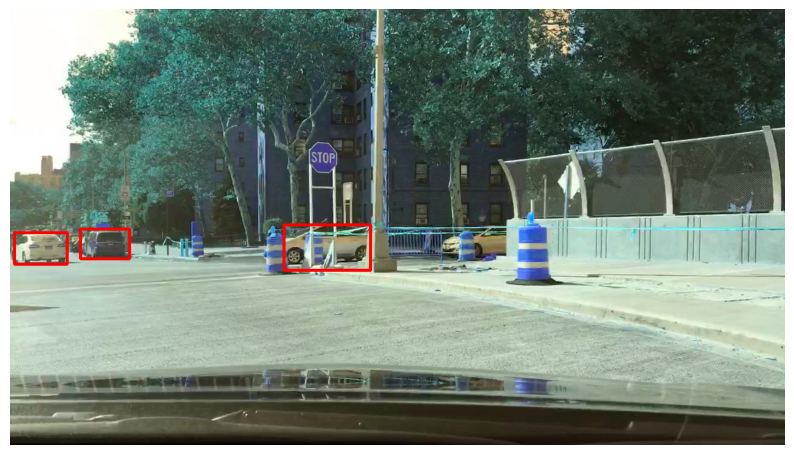

In [56]:
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")
    plt.show()

color_map = {
    "car": (0, 0, 255),
    "truck": (0, 0, 100),
    "pedestrian": (255, 0, 0),
    "other vehicle": (0, 0, 150),
    "rider": (200, 100, 0),
    "bicycle": (0, 255, 0),
    "other person": (200, 0, 0),
    "trailer": (0, 150, 150),
    "motorcycle": (0, 150, 0),
    "bus": (0, 0, 100),
}

img = cv.imread('frames_v2/01c71072-718028b8-0000002.jpg')
img = np.array(img)


img_example = img.copy()
# frame_labels = df_cleaned[df_cleaned['name'] == img_example]
for i, d in enumerate(results[0].boxes.xyxy):
    pt1 = int(d[0]), int(d[1])
    pt2 = int(d[2]), int(d[3])
    # color = color_map[d['category']]
    cv.rectangle(img_example, pt1, pt2, (0,0,255), 3)
display_cv2_img(img_example)

In [60]:
df_cleaned[df_cleaned['videoName'] == vid]['name'].unique()

array(['001c5339-08faca55-0000002.jpg', '001c5339-08faca55-0000003.jpg', '001c5339-08faca55-0000004.jpg', '001c5339-08faca55-0000005.jpg', '001c5339-08faca55-0000006.jpg', '001c5339-08faca55-0000007.jpg', '001c5339-08faca55-0000008.jpg', '001c5339-08faca55-0000009.jpg', '001c5339-08faca55-0000010.jpg',
       '001c5339-08faca55-0000011.jpg', '001c5339-08faca55-0000012.jpg', '001c5339-08faca55-0000013.jpg', '001c5339-08faca55-0000014.jpg', '001c5339-08faca55-0000015.jpg', '001c5339-08faca55-0000016.jpg', '001c5339-08faca55-0000017.jpg', '001c5339-08faca55-0000018.jpg', '001c5339-08faca55-0000019.jpg',
       '001c5339-08faca55-0000020.jpg', '001c5339-08faca55-0000021.jpg', '001c5339-08faca55-0000022.jpg', '001c5339-08faca55-0000023.jpg', '001c5339-08faca55-0000024.jpg', '001c5339-08faca55-0000025.jpg', '001c5339-08faca55-0000026.jpg', '001c5339-08faca55-0000027.jpg', '001c5339-08faca55-0000028.jpg',
       '001c5339-08faca55-0000029.jpg', '001c5339-08faca55-0000030.jpg', '001c5339-08fac

In [80]:
def yolo_videoPredict(path, videoName, df_cleaned, chosen_model, classes=[], conf=0.5):

    import cv2 as cv

    # list of frame jpg images for the desired video
    frames = df_cleaned[df_cleaned['videoName'] == videoName]['name'].unique()

    # initialize the results for the video:
    results = []
    result_imgs = []

    # use specified model:
    chosen_model = chosen_model


    # function for predicting
    def predict(chosen_model, img, classes=classes, conf=conf):
        '''
        chosen_model = YOLO model being used
        img = image to make prediction on 
        classes = list of classes/labels to filter predictions for
        conf = minimum confidence threshold for the prediction to be considered 
        '''
        if classes:
            results = chosen_model.predict(img, classes=classes, conf=conf)
        else:
            results = chosen_model.predict(img, conf=conf)

        return results

    # function for both predicting & detecting 
    def predict_and_detect(chosen_model, img, classes=classes, conf=conf):
        '''
        chosen_model = YOLO model being used
        img = image to make prediction on 
        classes = list of classes/labels to filter predictions for
        conf = minimum confidence threshold for the prediction to be considered 
        '''
        results = predict(chosen_model, img, classes, conf=conf)

        for result in results:
            for box in result.boxes:
                cv.rectangle(img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                            (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (0, 0, 255), 2)
                cv.putText(img, f"{result.names[int(box.cls[0])]}",
                            (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                            cv.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        return img, results
    
    # function for displaying image
    def display_cv2_img(img, figsize=(10, 10)):
        img_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(img_)
        ax.axis("off")
        plt.show()
    
    ### TEMPORARY COUNT FOR BREAK ###
    count = 0
    ### ### ### ###
    
    # run these functions on every frame of the video
    for f in frames:
        if count == 20:
            break
        # load in the jpg image of frame
        img = cv.imread(f'{path}/{f}')
        img = np.array(img)
        img_example = img.copy()
        # predict & detect & save results
        result_img, result = predict_and_detect(model, img_example, classes=[], conf=conf)
        results.append(result)
        result_imgs.append(result_img)

        display_cv2_img(result_img)

        count += 1

    return result_imgs, results




0: 384x640 3 cars, 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


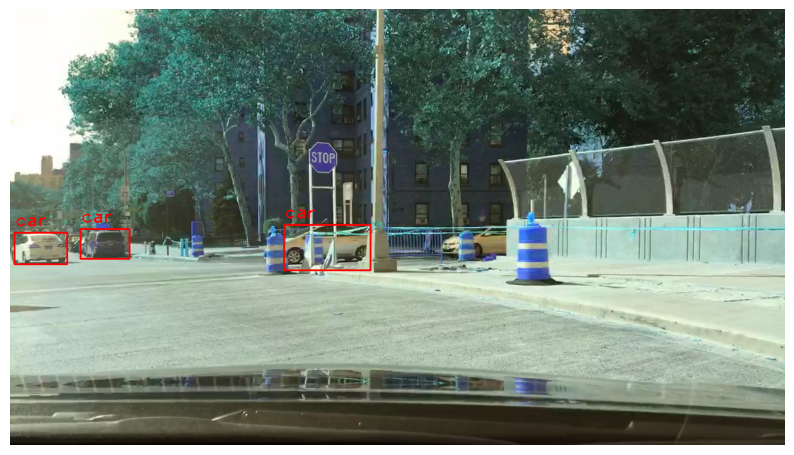


0: 384x640 6 cars, 1 stop sign, 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


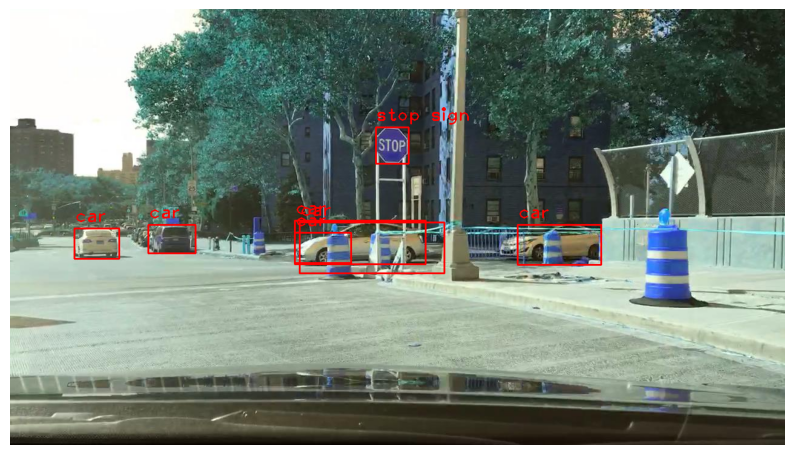


0: 384x640 6 cars, 1 fire hydrant, 1 stop sign, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


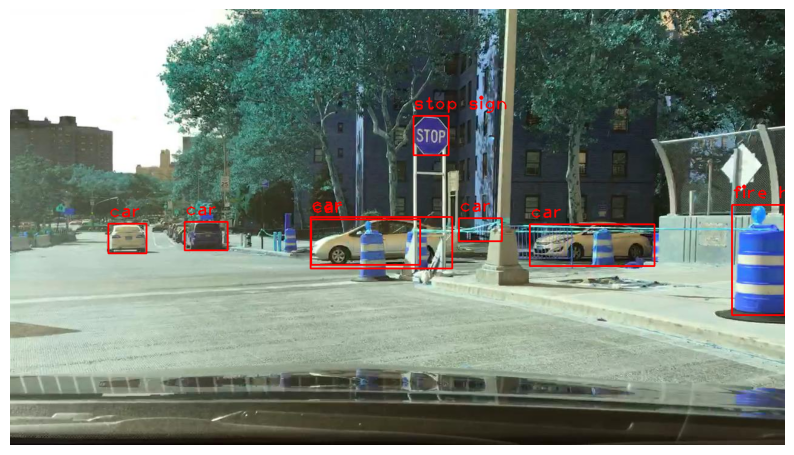


0: 384x640 5 cars, 1 stop sign, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


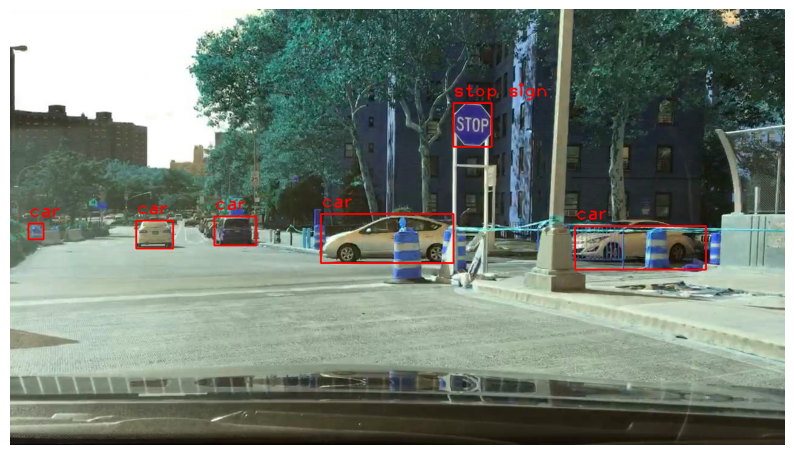


0: 384x640 3 cars, 1 stop sign, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


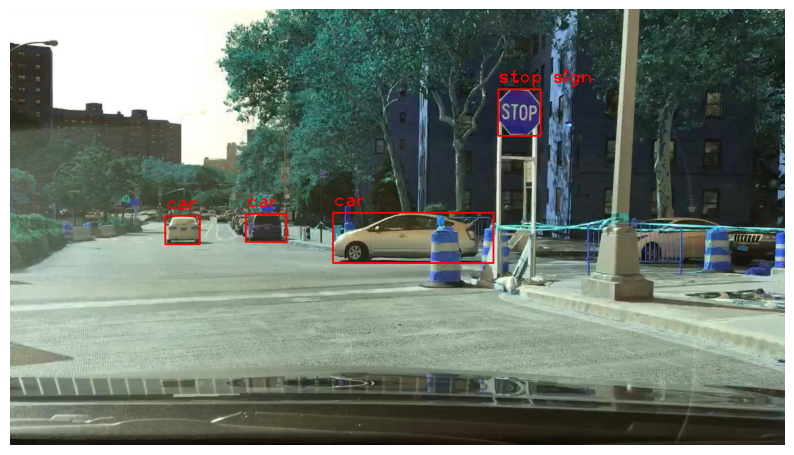

In [81]:
resulting_imgs, results = yolo_videoPredict(path, video, df_cleaned, model, classes=labels, conf=0.25)

'01c71072-718028b8'